In [2]:
from lmfit import minimize, Parameters

import pandas as pd
import tellurium as te
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX

import os 
os.chdir('..')
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks')

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# import the data 
df = pd.read_csv('../data/Simplified_Teusink_yeast_1.05.csv')

In [4]:
r = te.loada('../models/Simplified_Teusink_yeast.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

In [5]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

v_star = df[fluxes].loc[0]

In [6]:
ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

In [7]:
en = df[enzymes].loc[1:len(r.getReactionIds())]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(r.getReactionIds())]/df[internal].loc[0]
vn = df[fluxes].loc[1:len(r.getReactionIds())]/df[fluxes].loc[0]
yn = df[external].iloc[-(len(vn)):]/df[external].loc[0]


## Using lmfit to predict elasticity values w/o ey values

In [8]:
def cb(params, iter, resid, *args, **kws):
    print(iter, (resid**2).sum().sum())

def residual(params, xn, yn, v_star, df, *args, **kws):
    
    ex_params = [params[ii] for ii in [i for i in params]]
    ex = np.asarray(ex_params).reshape((16,11))
    
    a = (en.values*v_star.values)
    bb = np.ones((16,16))
    cc = ex@(np.log(xn)).T

    model = a.T*(bb + cc)

    return (df[fluxes].loc[1:len(r.getReactionIds())].values-model.T).values

    #model = np.diag(v_star)@(np.ones((16,19)) + ex@np.log(xn).T + ey@np.log(yn).T)
    #return (df[fluxes].loc[1:].values-model.T)

params = Parameters()

for i in range(16*(11)):
    params.add('Ex'+str(i), value=0, min=-10, max=10)

out = minimize(residual, params, args=(xn, yn, v_star, df))#, iter_cb=cb)

print(out.chisqr)
# out.params

7.162129346270159e-07


In [9]:
lmfit_ex = np.array([i.value for i in out.params.values()])
np.where(np.abs(lmfit_ex) > 0.01)

(array([  0,   1,  12,  13,  23,  34,  46,  47,  58,  59,  70,  71,  82,
         83,  94,  95, 106, 107, 118, 119, 130, 131, 142, 143, 164, 169],
       dtype=int64),)

In [10]:
out.params['Ex13'].value

-0.9540906588775258

In [11]:
ex

               GLCi,      G6P,       F6P,     F16P,      TRIO,       BPG,      P3G,       P2G,       PEP,       PYR,      ACE
vGLK   [[   1.44964, -1.43765,         0,        0,         0,         0,        0,         0,         0,         0,        0],
vPGI    [         0,  1.40347, -0.953057,        0,         0,         0,        0,         0,         0,         0,        0],
vGLYCO  [         0,        1,         0,        0,         0,         0,        0,         0,         0,         0,        0],
vTreha  [         0,        1,         0,        0,         0,         0,        0,         0,         0,         0,        0],
vPFK    [         0,        0,   1.38303, -1.03688,         0,         0,        0,         0,         0,         0,        0],
vALD    [         0,        0,         0,  1.10649, -0.823896,         0,        0,         0,         0,         0,        0],
vGAPDH  [         0,        0,         0,        0,  0.969712, -0.705532,        0,         0,         0, 

Now, we are going to explore control coefficient values for each set of elasticity values predicted by lmfit

In [12]:
def estimate_CCs(Ex):
    vn[vn == 0] = 1e-6
    
    a = np.diag(en.values / vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1, axis=0)

    Ex_ss = a @ Ex
    As = N @ np.diag(v_star) @ Ex_ss
    bs = N @ np.diag(v_star)
    bs = bs[np.newaxis, :].repeat(1, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(N.T))
    identity = identity[np.newaxis,:].repeat(1, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return -FCC

In [13]:
lmfit_ex_df = pd.DataFrame(lmfit_ex.reshape((16,11)), index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())
FCC_estimates = np.squeeze(estimate_CCs(lmfit_ex_df.values))

In [14]:
FCC_estimates[0]

array([-1.80606096e+00,  5.13373389e-02,  1.91238828e-02,  1.95488580e-01,
        3.53763380e-02,  3.31154584e-02,  1.61423796e-02,  1.22314548e-02,
        8.61649212e-03,  5.27647093e-03,  5.60849004e-03,  3.49773169e-03,
        3.15888202e-04,  4.07186661e-01,  7.61420852e-04,  1.19823764e-02])

In [15]:
r.getScaledFluxControlCoefficientMatrix()[0]

[1.97827702e-01 5.10757773e-02 1.89554933e-02 1.93767264e-01
 3.51968189e-02 3.29828174e-02 1.58676664e-02 1.20388199e-02
 8.49372163e-03 5.19193084e-03 5.57501480e-03 3.47188097e-03
 2.80782735e-04 4.06810162e-01 6.76802198e-04 1.17873451e-02]

In [16]:
FCC_estimates[5]

array([ 1.07719943e-01,  2.36109151e-01, -1.58929312e-02, -1.62461075e-01,
        1.62721844e-01, -1.84767916e+00,  7.42276875e-02,  5.62219789e-02,
        3.95763293e-02,  2.41947930e-02,  2.57223537e-02,  1.60017425e-02,
        1.40114919e-03,  2.23765138e-01,  3.37734744e-03,  5.49937106e-02])

In [17]:
r.getScaledFluxControlCoefficientMatrix()[5]

[ 0.10793611  0.23703552 -0.01581667 -0.1616815   0.1633435   0.15306863
  0.07363961  0.05587047  0.03941817  0.02409502  0.02587286  0.01611251
  0.00130307  0.22195833  0.00314094  0.05470341]

With the exception of the reaction being perturbed, the predicted FCC values match up quite well with the ground truth FCC values. 

## Using a dataset with variable perturbation strengths


In [18]:
# import the data 
df = pd.read_csv('../data/Simplified_Teusink_yeast_mixed.csv')

r = te.loada('../models/Simplified_Teusink_yeast.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]



In [19]:
v_star = df[fluxes].loc[0]

ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

en = df[enzymes].loc[1:len(r.getReactionIds())]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(r.getReactionIds())]/df[internal].loc[0]
vn = df[fluxes].loc[1:len(r.getReactionIds())]/df[fluxes].loc[0]
yn = df[external].iloc[-(len(vn)):]/df[external].loc[0]


In [20]:
def residual(params, xn, v_star, df, *args, **kws):
    
    ex_params = [params[ii] for ii in [i for i in params]]
    ex = np.asarray(ex_params).reshape((16,11))
    
    a = (en.values*v_star.values)
    bb = np.ones((16,16))
    cc = ex@(np.log(xn)).T

    model = a.T*(bb + cc)

    return (df[fluxes].loc[1:len(r.getReactionIds())].values-model.T).values

    #model = np.diag(v_star)@(np.ones((16,19)) + ex@np.log(xn).T + ey@np.log(yn).T)
    #return (df[fluxes].loc[1:].values-model.T)

params = Parameters()

for i in range(16*(11)):
    params.add('Ex'+str(i), value=0, min=-10, max=10)

out = minimize(residual, params, args=(xn, v_star, df))#, iter_cb=cb)

print(out.chisqr)
# out.params

0.0023103310061918453


## Removing perturbations from certain enzymes. 

In [47]:
r = te.loada('../models/Simplified_Teusink_yeast.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

In [30]:
# import the data 
df = pd.read_csv('../data/Simplified_Teusink_yeast_missing3.csv')

v_star = df[fluxes].loc[0]

ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

en = df[enzymes].loc[1:len(r.getReactionIds())]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(r.getReactionIds())]/df[internal].loc[0]
vn = df[fluxes].loc[1:len(r.getReactionIds())]/df[fluxes].loc[0]
yn = df[external].iloc[-(len(vn)):]/df[external].loc[0]


In [31]:
def residual(params, xn, v_star, df, *args, **kws):
    
    ex_params = [params[ii] for ii in [i for i in params]]
    ex = np.asarray(ex_params).reshape((16,11))
    
    a = (en.values*v_star.values)
    bb = np.ones((16,16))
    cc = ex@(np.log(xn)).T

    model = a.T*(bb + cc)

    return (df[fluxes].loc[1:len(r.getReactionIds())].values-model.T).values

params = Parameters()

for i in range(16*(11)):
    params.add('Ex'+str(i), value=0, min=-10, max=10)

out = minimize(residual, params, args=(xn, v_star, df))#, iter_cb=cb)

print(out.chisqr)
# out.params

0.00039463347995048336


In [34]:
mis3_ex = np.array([i.value for i in out.params.values()]).reshape((16,11))
mis3_ex = pd.DataFrame(mis3_ex, columns=r.getFloatingSpeciesIds(), index=r.getReactionIds())
mis3_ex

,GLCi,G6P,F6P,F16P,TRIO,BPG,P3G,P2G,PEP,PYR,ACE
vGLK,1.539948,-1.604117,0.002775,-0.002644,-0.006548,0.000134,-0.001218,-0.038112,0.029403,-0.000099,-0.000093
vPGI,-0.002822,1.400024,-0.941441,-0.033149,0.019292,0.000627,-0.001031,0.002425,-0.001699,-0.000004,-0.000003
vGLYCO,0.030555,1.050610,-0.007963,0.007155,-0.000657,-0.000152,0.003266,0.015563,-0.014897,0.000238,0.000216
vTreha,0.026246,1.056017,-0.003816,0.007633,0.000613,-0.000172,0.001103,0.024315,-0.018970,0.000076,0.000072
vPFK,-0.001787,-0.003154,1.340182,-1.055313,0.053554,0.001817,-0.002676,0.055798,-0.041333,0.000031,0.000035
vALD,-0.001068,-0.001929,0.002729,1.110600,-0.822750,0.005929,-0.008130,-0.030550,0.022683,-0.000009,-0.000010
vGAPDH,-0.001779,-0.003172,0.004531,-0.018345,0.970912,-0.648302,-0.034657,-0.040192,0.029803,0.000013,0.000014
vPGK,-0.001350,-0.002414,0.003441,-0.014324,0.014354,0.833785,-0.593567,0.101816,-0.075670,0.000148,0.000164
vPGM,-0.001090,-0.001954,0.002781,-0.011894,0.011890,0.002419,0.930597,-0.660776,0.007194,0.000271,0.000300
vENO,-0.000607,-0.001084,0.001547,-0.006427,0.006441,0.001360,-0.002075,1.057745,-0.784660,0.000593,0.000669


## How many perturbations do you even need?

In [36]:
missing_data_filenames = [
    '../data/Simplified_Teusink_yeast_1.05.csv',
    '../data/Simplified_Teusink_yeast_missing3.csv',
    '../data/Simplified_Teusink_yeast_missing6.csv',
    '../data/Simplified_Teusink_yeast_missing9.csv',
    '../data/Simplified_Teusink_yeast_missing12.csv'
]

In [71]:
mis_exs = [ex.flatten()]
for f in missing_data_filenames:
    df = pd.read_csv(f)

    v_star = df[fluxes].loc[0]

    ex = r.getScaledElasticityMatrix()

    a = r.getBoundarySpeciesIds()
    b = r.getReactionIds()
    c=[]
    for i in b: 
        for ii in a: 
            c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
    ey = np.array(c).reshape((len(b),len(a)))

    en = df[enzymes].loc[1:len(r.getReactionIds())]/df[enzymes].loc[0]
    xn = df[internal].loc[1:len(r.getReactionIds())]/df[internal].loc[0]
    vn = df[fluxes].loc[1:len(r.getReactionIds())]/df[fluxes].loc[0]
    yn = df[external].iloc[-(len(vn)):]/df[external].loc[0]
    
    out = minimize(residual, params, args=(xn, v_star, df))#, iter_cb=cb)
    mis_exs.append(np.array([i.value for i in out.params.values()]))

In [72]:
mis_results = pd.DataFrame(mis_exs)
mis_results

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,175
0,1.449644,-1.437645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.539948,-1.604117,0.002775,-0.002644,-0.006548,0.000134,-0.001218,-0.038112,0.029403,-0.000099,...,0.033955,-0.049456,0.171472,0.865629,-0.019124,0.028644,0.038231,-0.029005,0.000027,0.000022
2,1.568559,-9.768224,5.475394,0.301089,4.588298,-2.533875,-0.100082,0.774685,-0.574883,0.000583,...,5.050747,-3.409659,-0.027794,-0.938000,0.851019,0.054953,-1.622156,1.203483,-0.001060,-0.001178
3,1.543411,-1.597797,-0.850407,0.683284,-0.231257,0.196580,0.013591,0.825212,-0.612124,-0.010507,...,0.033856,0.081933,0.063328,1.251614,-0.285852,0.014058,-0.500292,0.371182,0.007193,-0.002390
4,1.450789,-1.063106,0.477022,-0.368915,0.095643,-0.077882,-0.005619,-0.286662,0.212637,0.003624,...,9.326050,-0.176398,3.636492,-0.821293,-0.374492,-0.008391,0.589945,-0.437634,-0.007798,0.002588


In [73]:
mis_difs = [i - ex.flatten() for i in mis_exs]
mis_difs_df = pd.DataFrame(mis_difs)
mis_difs_df

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,175
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.090305,-0.166472,0.002775,-0.002644,-0.006548,0.000134,-0.001218,-0.038112,0.029403,-0.000099,...,0.033955,-0.049456,0.171472,-0.134371,-0.019124,0.028644,0.038231,-0.029005,0.000027,0.000022
2,0.118915,-8.330579,5.475394,0.301089,4.588298,-2.533875,-0.100082,0.774685,-0.574883,0.000583,...,5.050747,-3.409659,-0.027794,-1.938000,0.851019,0.054953,-1.622156,1.203483,-0.001060,-0.001178
3,0.093767,-0.160152,-0.850407,0.683284,-0.231257,0.196580,0.013591,0.825212,-0.612124,-0.010507,...,0.033856,0.081933,0.063328,0.251614,-0.285852,0.014058,-0.500292,0.371182,0.007193,-0.002390
4,0.001145,0.374539,0.477022,-0.368915,0.095643,-0.077882,-0.005619,-0.286662,0.212637,0.003624,...,9.326050,-0.176398,3.636492,-1.821293,-0.374492,-0.008391,0.589945,-0.437634,-0.007798,0.002588


Text(0.5, 1.0, 'absolute error of ex values when perturbation data is missing')

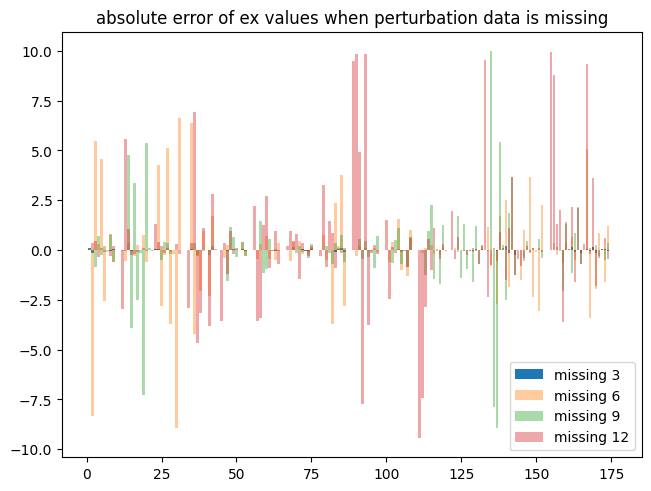

In [83]:
fig, ax = plt.subplots(layout='constrained')
ax.bar(np.arange(1,16*11+1,1),mis_difs_df.iloc[1], label='missing 3')
ax.bar(np.arange(1,16*11+1,1),mis_difs_df.iloc[2], alpha=0.4, label='missing 6')
ax.bar(np.arange(1,16*11+1,1),mis_difs_df.iloc[3], alpha=0.4, label='missing 9')
ax.bar(np.arange(1,16*11+1,1),mis_difs_df.iloc[4], alpha=0.4, label='missing 12')
ax.legend(loc='lower right')
ax.set_title('absolute error of ex values when perturbation data is missing')

## Using Bayesian inference

Now that we have the math squared away, we will use Bayesian inference and see if we can get comparable results to lmfit.


In [15]:
# switch kernel to pytensor5 here
import cobra
import logging
logging.getLogger("cobra").setLevel(logging.ERROR)

import pandas as pd
import tellurium as te
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pytensor
import pymc as pm

import emll

import arviz as az

In [3]:
df = pd.read_csv('../data/Simplified_Teusink_yeast_1.05.csv')
r = te.loada('../models/Simplified_Teusink_yeast.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

v_star = df[fluxes].loc[0]

ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

en = df[enzymes].loc[1:len(r.getReactionIds())]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(r.getReactionIds())]/df[internal].loc[0]
vn = df[fluxes].loc[1:len(r.getReactionIds())]/df[fluxes].loc[0]
yn = df[external].iloc[-(len(vn)):]/df[external].loc[0]


In [4]:
# load cobra version of model

model = cobra.io.read_sbml_model('../models/Simplified_Teusink_yeast_cobra.xml')
# cobra.util.create_stoichiometric_matrix(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


No objective coefficients in model. Unclear what should be optimized


In [5]:
# Set up the Bayesian inference
r_compartments = [r.compartments if 'e' not in r.compartments else 't' for r in model.reactions]

for rxn in model.exchanges:
    r_compartments[model.reactions.index(rxn)] = 't'

m_compartments = [m.compartment for m in model.metabolites]
internal_mets = [i for i in model.metabolites if i.compartment!='e']
rxnNames = [i.id for i in model.reactions]
v_inds = np.arange(0,len(v_star))
n_exp = vn.shape[0]


In [6]:
def create_Visser_elasticity_matrix():

    r = te.loada('../models/Simplified_Teusink_yeast_cobra.ant')
    r.conservedMoietyAnalysis = True
    
    n_metabolites = len(model.metabolites)
    n_reactions = len(model.reactions)
    array = np.zeros((n_reactions, n_metabolites), dtype=float)

    m_ind = model.metabolites.index
    r_ind = model.reactions.index

    for reaction in model.reactions:
        for metabolite, stoich in reaction.metabolites.items():

            # Reversible reaction, assign all elements to -stoich
            if reaction.reversibility:
                array[r_ind(reaction), m_ind(metabolite)] = -np.sign(stoich)

            # Irrevesible in forward direction, only assign if met is reactant
            elif ((not reaction.reversibility) & 
                (reaction.upper_bound > 0) &
                (stoich < 0)):
                array[r_ind(reaction), m_ind(metabolite)] = -np.sign(stoich)

            # Irreversible in reverse direction, only assign if met is product
            elif ((not reaction.reversibility) & 
                (reaction.lower_bound < 0) &
                (stoich > 0)):
                array[r_ind(reaction), m_ind(metabolite)] = -np.sign(stoich)

    array = emll.util.create_elasticity_matrix(model)
    array = pd.DataFrame(array, index=r.getReactionIds(), columns=[i.id for i in model.metabolites])
    array = array.loc[:,r.getFloatingSpeciesIds()]
    return array

In [10]:
with pm.Model() as pymc_model:
    
    Ex_t = pm.Normal('Ex', mu=create_Visser_elasticity_matrix().values)
    Ey_t = pm.Normal('Ey', mu=np.zeros((16,3)), sigma=4)

    likelihood = (en.values)*(np.ones((16,16)) + pm.math.dot(Ex_t, xn.T) + pm.math.dot(ey,yn.T))
    vn_t = pm.Normal('vn_t', mu=likelihood, sigma=0.1, observed=vn)


In [13]:
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = pm.fit(n=80000)

Finished [100%]: Average Loss = 305.15


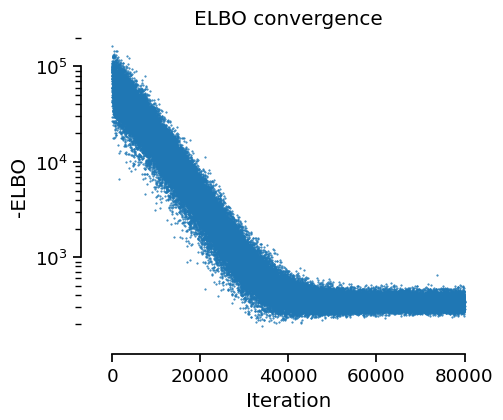

In [16]:
with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4),dpi=100)
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    plt.yscale("log")
    
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('ELBO convergence')

In [18]:
idata = approx.sample(1000)

In [19]:
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Ex[0, 0]",-0.967,0.028,-1.017,-0.914,0.001,0.001,1010.0,1026.0,NaN
"Ex[0, 1]",0.011,0.029,-0.046,0.065,0.001,0.001,982.0,983.0,NaN
"Ex[0, 2]",0.005,0.028,-0.046,0.058,0.001,0.001,921.0,972.0,NaN
"Ex[0, 3]",0.000,0.027,-0.054,0.052,0.001,0.001,859.0,958.0,NaN
"Ex[0, 4]",-0.008,0.027,-0.061,0.040,0.001,0.001,923.0,1015.0,NaN
...,...,...,...,...,...,...,...,...,...
"Ey[14, 1]",0.154,4.493,-7.396,9.031,0.148,0.105,924.0,940.0,NaN
"Ey[14, 2]",0.077,4.450,-8.241,8.146,0.139,0.100,1021.0,936.0,NaN
"Ey[15, 0]",-0.073,4.306,-7.962,8.225,0.134,0.105,1020.0,852.0,NaN
"Ey[15, 1]",0.202,4.241,-7.962,7.692,0.131,0.106,1046.0,910.0,NaN


Perhaps it is failing to fit Ex when Ey is also being fitted just like lmfit. Let's fix Ey and see if pymc performs better with fitting Ex. 


In [68]:
with pm.Model() as pymc_model:
    
    Ex_t = pm.Normal('Ex', mu=create_Visser_elasticity_matrix().values)

    likelihood = (en.values*v_star.values)*(np.ones((16,16)) + pm.math.dot(Ex_t, xn.T) + pm.math.dot(ey,yn.T))
    v = pm.Normal('v', mu=likelihood, sigma=0.1, observed=vn*v_star)
    

In [69]:
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = pm.fit(n=80000)

Finished [100%]: Average Loss = 377.1


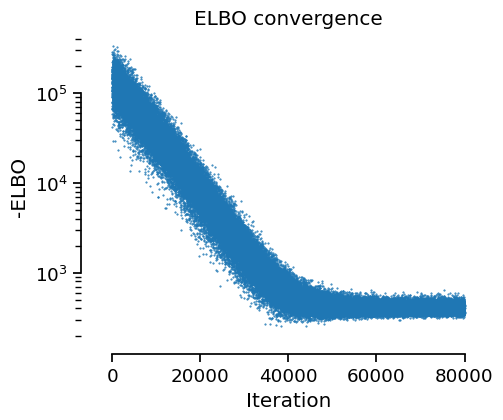

In [70]:
with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4),dpi=100)
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    plt.yscale("log")
    
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('ELBO convergence')

In [71]:
idata = approx.sample(1000)

In [72]:
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Ex[0, 0]",-0.924,0.019,-0.960,-0.888,0.001,0.0,1106.0,936.0,NaN
"Ex[0, 1]",0.011,0.020,-0.027,0.047,0.001,0.0,847.0,907.0,NaN
"Ex[0, 2]",0.005,0.020,-0.031,0.041,0.001,0.0,971.0,1014.0,NaN
"Ex[0, 3]",-0.000,0.020,-0.035,0.038,0.001,0.0,956.0,748.0,NaN
"Ex[0, 4]",-0.006,0.019,-0.041,0.030,0.001,0.0,975.0,1020.0,NaN
...,...,...,...,...,...,...,...,...,...
"Ex[15, 6]",-0.079,0.018,-0.113,-0.044,0.001,0.0,1186.0,1025.0,NaN
"Ex[15, 7]",-0.076,0.020,-0.112,-0.038,0.001,0.0,908.0,983.0,NaN
"Ex[15, 8]",-0.075,0.019,-0.107,-0.039,0.001,0.0,1099.0,926.0,NaN
"Ex[15, 9]",-0.083,0.019,-0.121,-0.049,0.001,0.0,1029.0,923.0,NaN


In [73]:
Ex_pytensor = np.squeeze(idata['posterior']['Ex'].to_numpy())

In [74]:
Ex_pytensor.shape

(1000, 16, 11)

In [75]:
Ex_pytensor = az.summary(idata)['mean'].values
Ex_pytensor = Ex_pytensor.reshape((16,11))


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [76]:
a = (en.values*v_star.values)*(np.ones((16,16)) + (ex@xn.T).values + (ey@yn.T).values)
a[0]

array([2.31282037, 1.05995151, 0.10984542, 0.56611844, 1.05915662,
       1.05904386, 1.72279794, 1.72248333, 1.7221924 , 1.72192348,
       1.7219502 , 1.72178022, 0.25239272, 2.33553511, 1.2167638 ,
       0.39350587])

In [77]:
b = (en.values*v_star.values)*(np.ones((16,16)) + (Ex_pytensor@xn.T).values + (ey@yn.T).values)
b[0]

array([2.44586353, 1.07989631, 0.10915869, 0.55595515, 1.07104964,
       1.06983621, 1.75957314, 1.66433166, 1.68103232, 1.69466914,
       1.69458176, 1.70134439, 0.25093384, 2.24096165, 1.2083301 ,
       0.38655903])

*could this be a new elasticity matrix that hits the points but is not the actual value?*

In [78]:
(a-b).sum() # <-- this is the summed error

158.43930092373262

## Solving elasticity values with pytensor/emll packages